In [1]:
import os
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, make_scorer, log_loss, brier_score_loss
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from xgboost import XGBClassifier

from skopt import BayesSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from skopt.space import Real, Integer

from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setup metrics (see: http://business-analytic.co.uk/blog/evaluating-expected-goals-models/)
# define Mcfadden's pseduo r-squared
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)

In [3]:
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

In [4]:
# Load the data
cwd = os.getcwd()
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','competition_gender','match_week'], axis=1, inplace=True)
mask_penalty = (df.shot_type_name=='penalty')
df_penalty = df[mask_penalty].copy()
df_penalty.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name','smart_pass','carry_length','pass_end_x','pass_end_y',
                 'goalkeeper_x', 'goalkeeper_y','n_angle','area_goal','area_shot','shot_one_on_one','shot_open_goal',
                'under_pressure'], axis=1, inplace=True)
df_non_penalty = df[~mask_penalty].copy()
X_penalty = df_penalty.drop('goal', axis=1)
y_penalty = df_penalty.goal
X = df_non_penalty.drop('goal', axis=1)
y = df_non_penalty.goal

In [5]:
# Split into train, calibration and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
X_penalty_train, X_penalty_test, y_penalty_train, y_penalty_test = train_test_split(X_penalty, y_penalty,
                                                                        train_size=0.8, random_state=42, stratify=y_penalty)

In [6]:
# Load and split fake data
df_fake = pd.read_parquet(os.path.join(cwd, 'data', 'fake_shots.parquet'))
df_fake.drop(['competition_gender','competition_gender','match_week'], axis=1, inplace=True)
df_fake.index = ['a'+str(idx) for idx in df_fake.index]

y_fake = df_fake.goal
X_fake = df_fake.drop('goal', axis=1)

In [7]:
# Add fake training data. I am not adding this to the test data as want this to be realistic of real data.
X_train = pd.concat([X_train, X_fake])
y_train = pd.concat([y_train, y_fake])

In [8]:
# Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.
def clean_lightgbm(df):
    df = df.copy()
    # replace categorical columns
    shot_type_cat = {'free_kick': 0, 'corner': 1, 'throw_in': 2, 'direct_set_piece': 3, 'open_play': 4}
    body_type_cat = {'Right Foot': 0, 'Left Foot': 1, 'Other': 2}
    assist_type_cat = {'pass': 0, 'recovery': 1, 'clearance': 2, 'direct': 3, 'rebound': 4}
    pass_height_cat = {'High Pass': 0, 'Ground/ Low Pass': 1}
    pass_technique_cat = {'Through Ball': 0, 'Straight': 1, 'Inswinging': 2, 'Outswinging': 3, 'other': 4}
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.shot_type_name.replace(shot_type_cat, inplace=True)
    df.body_part_name.replace(body_type_cat, inplace=True)
    df.assist_type.replace(assist_type_cat, inplace=True)
    df.pass_height_name.replace(pass_height_cat, inplace=True)
    df.pass_technique_name.replace(pass_technique_cat, inplace=True)
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    
    # replace boolean type columns (not really as have nans)
    for col in ['pass_switch', 'pass_cross', 'pass_cut_back', 'shot_one_on_one',
                'shot_open_goal', 'under_pressure', 'smart_pass']:
        df[col] = df[col].astype(np.float32)
    return df
    
X_train = clean_lightgbm(X_train)
X_test = clean_lightgbm(X_test)

In [9]:
# Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.
def clean_lightgbm_p(df):
    df = df.copy()
    # replace categorical columns
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    return df
    
X_penalty_train = clean_lightgbm_p(X_penalty_train)
X_penalty_test = clean_lightgbm_p(X_penalty_test)

In [10]:
xgb = CalibratedClassifierCV(XGBClassifier(random_state=42, eval_metric='logloss'), method='isotonic', cv=3)
xgb_param_grid = {'base_estimator__min_child_weight': Integer(0, 50),
                   'base_estimator__reg_lambda': Real(0, 1),
                   'base_estimator__reg_alpha': Real(0, 1),
                   'base_estimator__max_depth': Integer(0, 10)}

In [11]:
searchcv_xgb = BayesSearchCV(estimator=xgb,
                             n_iter=100,
                             search_spaces=xgb_param_grid,
                             cv=5,
                             n_jobs=-1)
searchcv_xgb.fit(X_train, y_train)
y_pred_xgb = searchcv_xgb.best_estimator_.predict_proba(X_test)

BayesSearchCV(cv=5,
              estimator=CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                                            booster=None,
                                                                            colsample_bylevel=None,
                                                                            colsample_bynode=None,
                                                                            colsample_bytree=None,
                                                                            eval_metric='logloss',
                                                                            gamma=None,
                                                                            gpu_id=None,
                                                                            importance_type='gain',
                                                                            interaction_constraints=None,
                 

In [13]:
# Permutation importance
perm_result_xgb = permutation_importance(searchcv_xgb.best_estimator_, X_train, y_train, n_repeats=10, random_state=42)
df_perm_importance_xgb = pd.DataFrame({'Feature':X_train.columns,
                                   'importance': perm_result_xgb.importances.mean(axis=1),
                                   'std_dev': perm_result_xgb.importances.std(axis=1)})
df_perm_importance_xgb.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_xgb.reset_index(drop=True, inplace=True)
df_perm_importance_xgb

,Feature,importance,std_dev
0,visible_angle,0.007112,0.000318
1,distance_to_goal,0.005214,0.000161
2,goalkeeper_x,0.001082,0.000184
3,body_part_name,0.000920,0.000169
4,n_angle,0.000783,0.000181
5,x,0.000677,0.000160
6,shot_type_name,0.000616,0.000167
7,area_shot,0.000380,0.000094
8,area_goal,0.000354,0.000112
9,pass_end_x,0.000298,0.000071


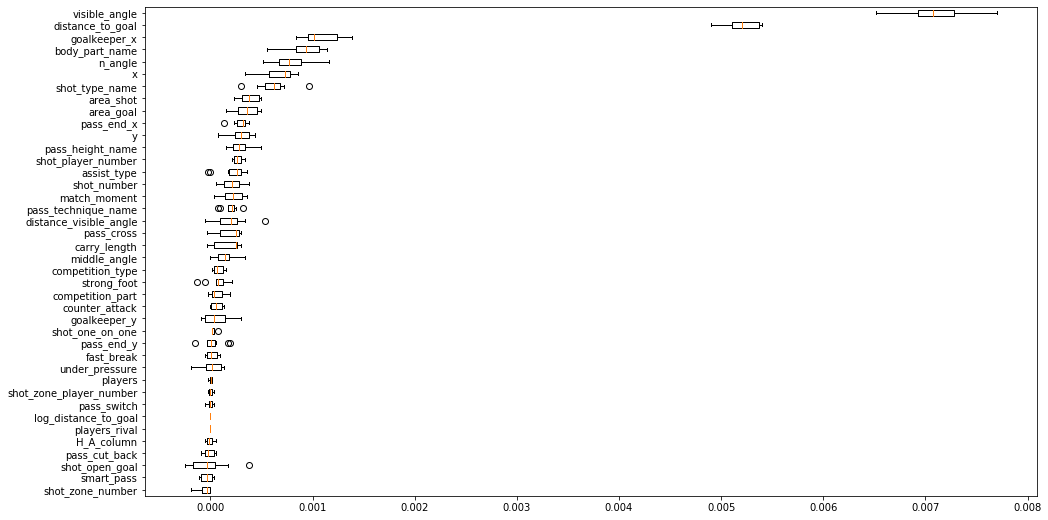

In [14]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_xgb.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_xgb.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])

In [15]:
searchcv_xgb_p = BayesSearchCV(estimator=xgb,
                             n_iter=25,
                             search_spaces=xgb_param_grid,
                             cv=5,
                             n_jobs=-1)
searchcv_xgb_p.fit(X_penalty_train, y_penalty_train)
y_pred_xgb_p = searchcv_xgb_p.best_estimator_.predict_proba(X_penalty_test)

In [17]:
# Permutation importance
perm_result_xgb_p = permutation_importance(searchcv_xgb_p, X_penalty_train, y_penalty_train, n_repeats=10, random_state=42)
df_perm_importance_xgb_p = pd.DataFrame({'Feature':X_penalty_train.columns,
                                   'importance': perm_result_xgb_p.importances.mean(axis=1),
                                   'std_dev': perm_result_xgb_p.importances.std(axis=1)})
df_perm_importance_xgb_p.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_xgb_p.reset_index(drop=True, inplace=True)
df_perm_importance_xgb_p

,Feature,importance,std_dev
0,competition_type,0.0,0.0
1,competition_part,0.0,0.0
2,H_A_column,0.0,0.0
3,match_moment,0.0,0.0
4,shot_number,0.0,0.0
5,shot_player_number,0.0,0.0
6,players,0.0,0.0
7,players_rival,0.0,0.0


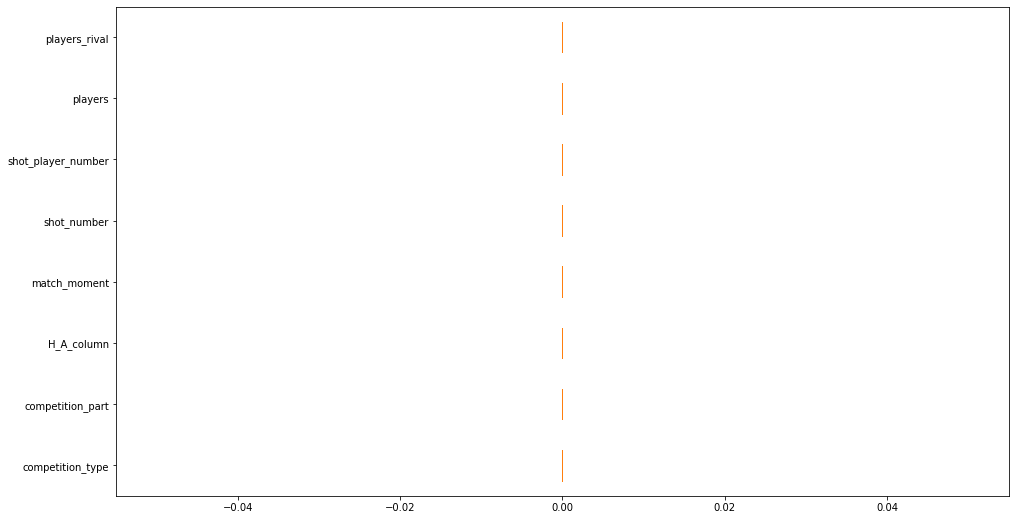

In [19]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_xgb_p.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_xgb_p.importances[sorted_idx].T, vert=False, labels=X_penalty_train.columns[sorted_idx])

In [20]:
# Calculate calibration curve on test data
fraction_of_positives_xgb, mean_predicted_value_xgb = calibration_curve(y_test, y_pred_xgb[:, 1], n_bins=10)

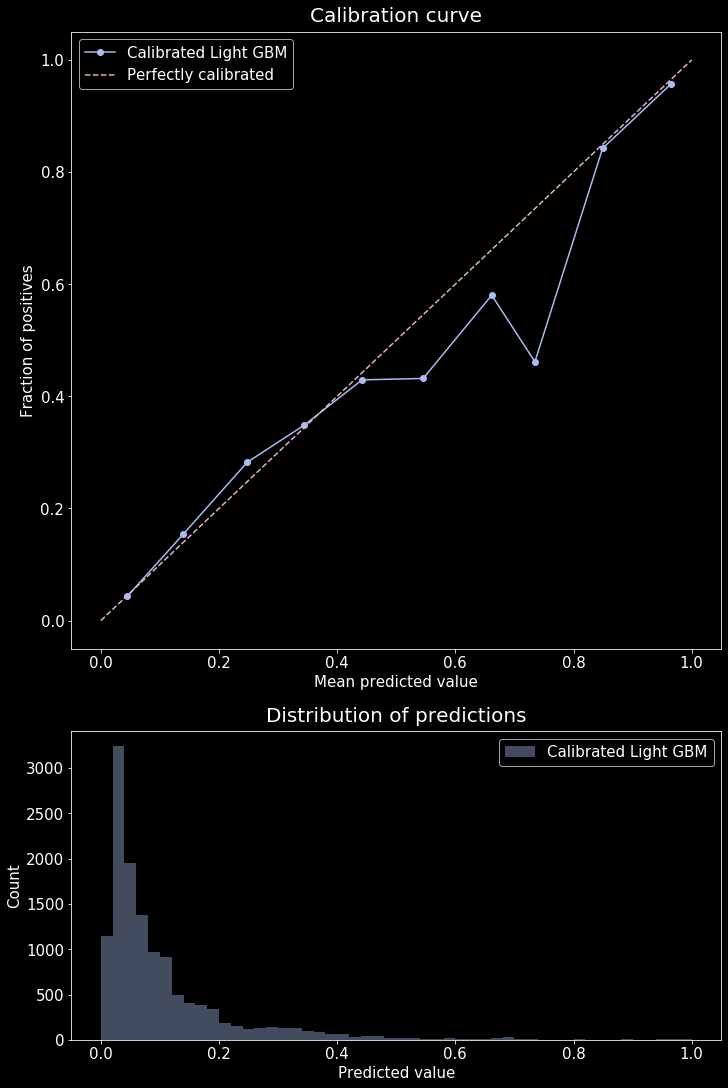

In [21]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_xgb, fraction_of_positives_xgb, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_xgb[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);

In [22]:
print("The log loss of the model with Random Search is: " + str(log_loss(y_test, y_pred_xgb)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_test, y_pred_xgb[:,1])))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_test, y_pred_xgb[:,1]))
print('Brier score, logistic regression:',brier_score_loss(y_test, y_pred_xgb[:,1], pos_label=y_test.max()))

The log loss of the model with Random Search is: 0.28101855167484097
The ROC AUC score of the model with Random Search is: 0.7909506604004883
Pseudo R-squared, logistic regression: 0.16931924703468204
Brier score, logistic regression: 0.08134918390322204


In [23]:
# Calculate calibration curve on test data
fraction_of_positives_xgb_p, mean_predicted_value_xgb_p = calibration_curve(y_penalty_test, y_pred_xgb_p[:, 1],
                                                                            n_bins=10)

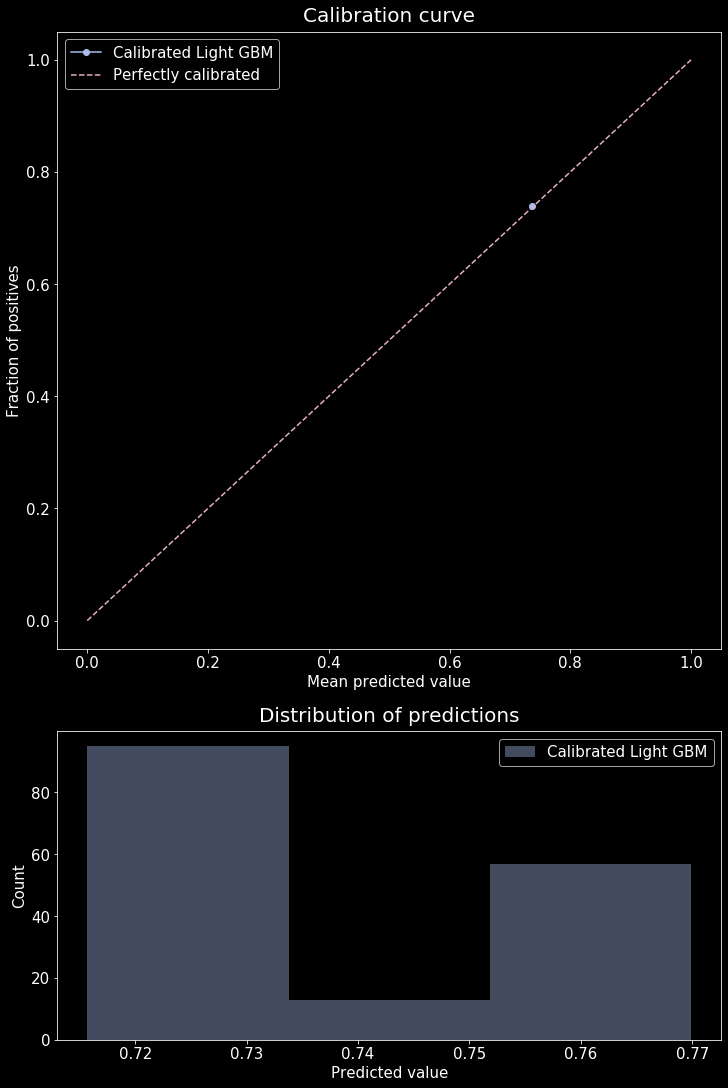

In [24]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_xgb_p, fraction_of_positives_xgb_p, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_xgb_p[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);

In [25]:
print("The log loss of the model with Random Search is: " + str(log_loss(y_penalty_test, y_pred_xgb_p)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_penalty_test, 
                                                                                  y_pred_xgb_p[:,1])))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_penalty_test, y_pred_xgb_p[:,1]))
print('Brier score, logistic regression:',brier_score_loss(y_penalty_test, y_pred_xgb_p[:,1], 
                                                           pos_label=y_penalty_test.max()))

The log loss of the model with Random Search is: 0.5757863660967175
The ROC AUC score of the model with Random Search is: 0.5026686999618758
Pseudo R-squared, logistic regression: -0.003654383239904302
Brier score, logistic regression: 0.1934882866364448


# Save models

In [27]:
dump(searchcv_xgb, os.path.join(cwd, 'models', 'xgb_model.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\xgb_model.joblib']

In [28]:
dump(searchcv_xgb_p, os.path.join(cwd, 'models', 'xgb_model_penalty.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\xgb_model_penalty.joblib']

# Save data

In [29]:
# reload shot dataset for ids
df3 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
mask_penalty = (df3.shot_type_name=='penalty')
df_penalty = df3[mask_penalty].copy()
df_non_penalty = df3[~mask_penalty].copy()
df_penalty = df_penalty[['match_id', 'wyscout_id', 'statsbomb_id']].copy()
df_non_penalty = df_non_penalty[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [30]:
X_train['goal'] = y_train
X_train['split'] = 'train'
X_test['goal'] = y_test
X_test['split'] = 'test'
df_lgbm = pd.concat([X_train, X_test])
# exlcude fake shots
df_lgbm = df_lgbm[df_lgbm.index.isin(df_non_penalty.index)].copy()
df_lgbm = df_lgbm.merge(df_non_penalty, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm.to_parquet(os.path.join(cwd, 'data', 'modelling', 'xgb.parquet'))

X_penalty_train['goal'] = y_penalty_train
X_penalty_train['split'] = 'train'
X_penalty_test['goal'] = y_penalty_test
X_penalty_test['split'] = 'test'
df_lgbm_penalty = pd.concat([X_penalty_train, X_penalty_test])
# exlcude fake shots
df_lgbm_penalty = df_lgbm_penalty[df_lgbm_penalty.index.isin(df_penalty.index)].copy()
df_lgbm_penalty = df_lgbm_penalty.merge(df_penalty, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm_penalty.to_parquet(os.path.join(cwd, 'data', 'modelling', 'xgb_penalty.parquet'))